### Programa para determinar los parámetros de la línea incluyendo la conductividad del terreno.

 Basado en el libro Power System Transients: Parameter Determination,
 Martinez Velasco.
 Programado por : Ernesto Pérez
   Marzo 10 de 2014


 Se ingresan los parámetros geométricos de la líena
 se determinan las distancias
 Se calculan los parámetros


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.collections as mcollections
import pandas as pd
from cond_clases  import *
import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D




### Definición de los objetos de conductores

In [5]:
mu_0=4* np.pi*1e-7
eps_0=8.85e-12

In [6]:
sigma_g=0.1
mu_gr=1
eps_gr=10
freq=60

cond_p=cable('flicker', r=0.0079, Rdc=0.102298851, Rac=0.125287356, Tac=75, Imax=659)#
cond_p2=cable('parakeet', r=0.010, Rdc=0.088218391, Rac=0.125287356, Tac=75, Imax=659)
cond_n=cable('OPGW AC47', r=0.0725, Rdc=0.3, Rac=0.3, Tac=75, Imax=400)
cond_1=conductor(cond_p,'a',0,20)
cond_2=conductor(cond_p,'b',6,20)
cond_3=conductor(cond_p,'c',12,20)
cond_1n=conductor(cond_n,'n',3,30)
cond_2n=conductor(cond_n,'n',9,30)
conductors=[cond_1,cond_2,cond_3,cond_1n,cond_2n]
#print(conductors)
T1=Tower('115kV',conductors)
Zall=calc_param(T1, freq, sigma_g, mu_gr, eps_gr)
print(Zall.z1*1000)


dij [[ 0.          6.         12.         10.44030651 13.45362405]
 [ 6.          0.          6.         10.44030651 10.44030651]
 [12.          6.          0.         13.45362405 10.44030651]
 [10.44030651 10.44030651 13.45362405  0.          6.        ]
 [13.45362405 10.44030651 10.44030651  6.          0.        ]]
Dij [[40.         40.44749683 41.76122604 50.08991915 50.80354318]
 [40.44749683 40.         40.44749683 50.08991915 50.08991915]
 [41.76122604 40.44749683 40.         50.80354318 50.08991915]
 [50.08991915 50.08991915 50.80354318 60.         60.29925373]
 [50.80354318 50.08991915 50.08991915 60.29925373 60.        ]]
Dijp [[245.46811373-205.46818231j 245.51123465-205.43209444j
  245.64062682-205.32388227j 255.47880975-205.45958007j
  255.5643871 -205.39078062j]
 [245.51123465-205.43209444j 245.46811373-205.46818231j
  245.51123465-205.43209444j 255.47880975-205.45958007j
  255.47880975-205.45958007j]
 [245.64062682-205.32388227j 245.51123465-205.43209444j
  245.46811373-

In [133]:
(cond_p.r-cond_p2.r)/cond_p.r*100


-26.58227848101265

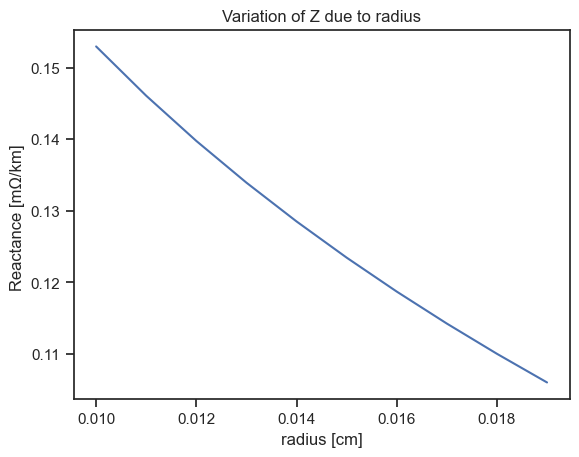

,radius,height,separation,z1
0,0.010,5.0,1.0,0.152973
1,0.011,5.0,1.0,0.146086
2,0.012,5.0,1.0,0.139773
3,0.013,5.0,1.0,0.133944
4,0.014,5.0,1.0,0.128529


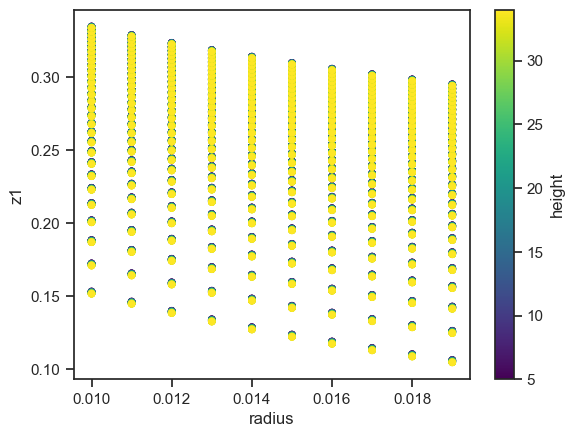

In [134]:
#h=[20,22,24,26,28,30]
heigths=[5+i for i in range(30)]
#sep=[2,3,4,5]
sep=[1+i*.2 for i in range(30)]
rcon = [cond_p2.r * (1 + 0.1 * i) for i in range(10)]  # Use list comprehension to populate rcon
z1_variation = []
data = pd.DataFrame(columns=['radius', 'height','separation','z1'])
i=0
ind_i=0
for s in sep:
    for i in range(T1.n_cond):
        if i>0 and i < T1.n_cond-1:
            T1.phases[i].pos_x = T1.phases[i-1].pos_x+s  # Assign the radius directly
        elif i>=T1.n_cond-1:
            T1.phases[i].pos_x = T1.phases[i-1].pos_x#height neutral conductor
    
    for h in heigths:
        for k in range(T1.n_cond):
            if k < T1.n_cond-1:
                T1.phases[k].pos_y = h  # Assign the radius directly
            else:
                T1.phases[k].pos_y = h+4 #height neutral conductor
        for r in rcon:
            for j in range(T1.n_cond):
                T1.phases[j].c.r = r  # Assign the radius directly
            Zall = calc_param(T1, freq, sigma_g, mu_gr, eps_gr)
            data.loc[ind_i] = [r, h, s, np.imag(Zall.z1)*1e3]
            z1_variation.append(np.imag(Zall.z1)*1e3)
            ind_i+=1
fig, ax = plt.subplots()
line, = ax.plot(rcon, z1_variation[0:10])
ax.set_title("Variation of Z due to radius")
ax.set_xlabel("radius [cm]")
ax.set_ylabel("Reactance [mΩ/km] ")
plt.show()
data.plot(x='radius', y='z1', kind='scatter', c='height', colormap='viridis')
display(data.head())

In [135]:
data_matrix=data.pivot_table(index='radius', columns='height', values='z1')
array_2d = data_matrix.to_numpy()
#display(data_matrix)

heigths.__len__()


30

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (30,).

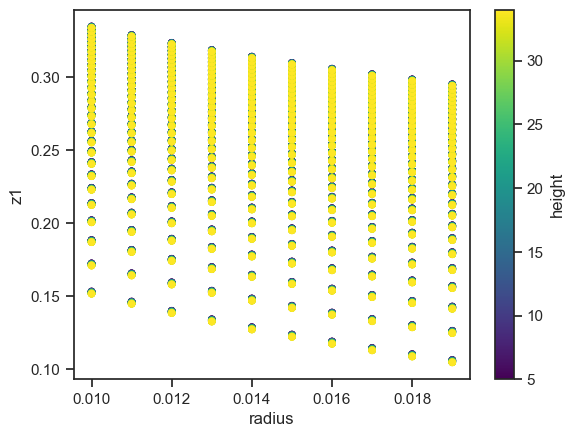

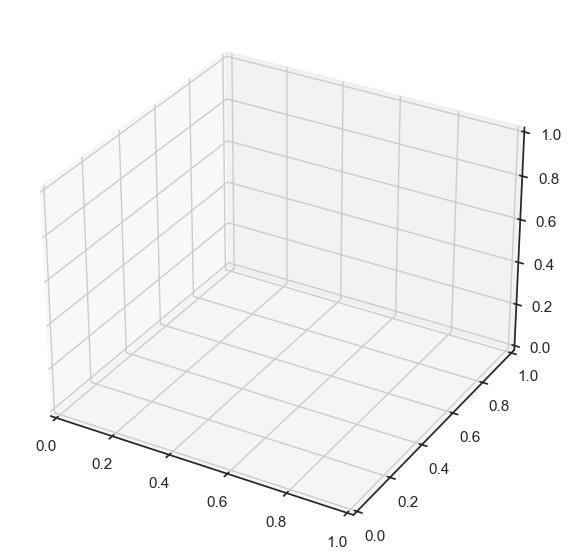

In [136]:
data.plot(x='radius', y='z1', kind='scatter',c='height',  colormap='viridis')
x, y = np.meshgrid(rcon, heigths)
#display(x)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(rcon, heigths, data_matrix.values, cmap='viridis')
ax.set_title('3D Surface Plot of z = sin(x) * cos(y)')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.tight_layout()
plt.show()


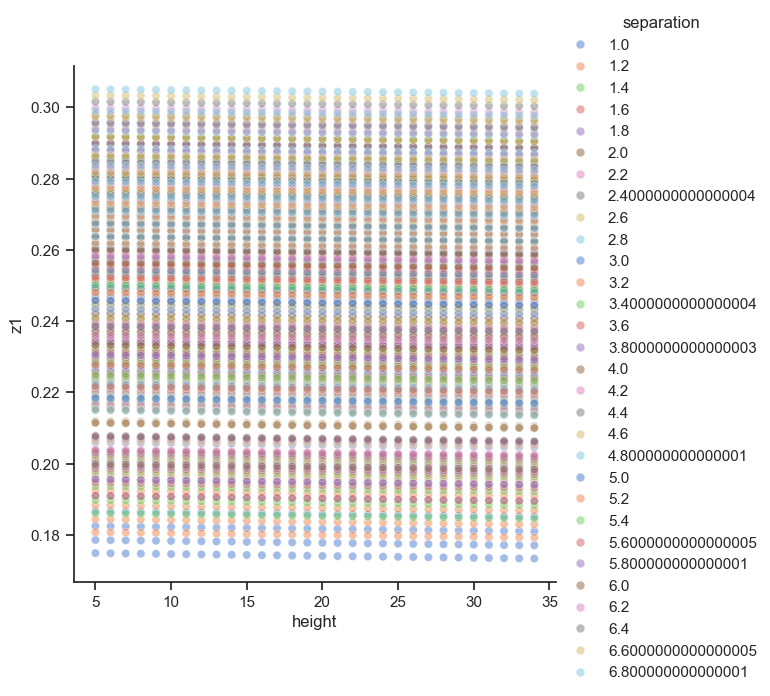

In [ ]:
sns.relplot(x="height", y="z1", hue="separation",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=data)

dij [[ 0.          6.         12.          3.          9.8488578 ]
 [ 6.          0.          6.          3.          5.        ]
 [12.          6.          0.          9.          5.        ]
 [ 3.          3.          9.          0.          7.21110255]
 [ 9.8488578   5.          5.          7.21110255  0.        ]]
Dij [[10.         11.66190379 15.62049935 10.44030651 16.64331698]
 [11.66190379 10.         11.66190379 10.44030651 14.31782106]
 [15.62049935 11.66190379 10.         13.45362405 14.31782106]
 [10.44030651 10.44030651 13.45362405 10.         15.23154621]
 [16.64331698 14.31782106 14.31782106 15.23154621 18.        ]]
Dijp [[2064.64718722-2054.71577147j 2064.65156735-2054.71141243j
  2064.66470777-2054.69833535j 2064.64828225-2054.71468171j
  2068.6570424 -2054.70598271j]
 [2064.65156735-2054.71141243j 2064.64718722-2054.71577147j
  2064.65156735-2054.71141243j 2064.64828225-2054.71468171j
  2068.64828224-2054.71468383j]
 [2064.66470777-2054.69833535j 2064.65156735-2054.7

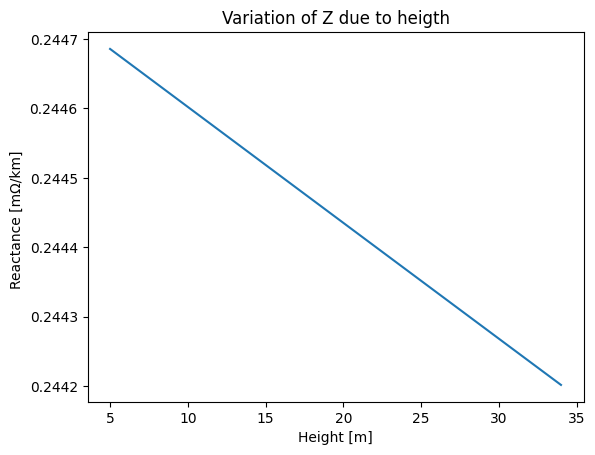

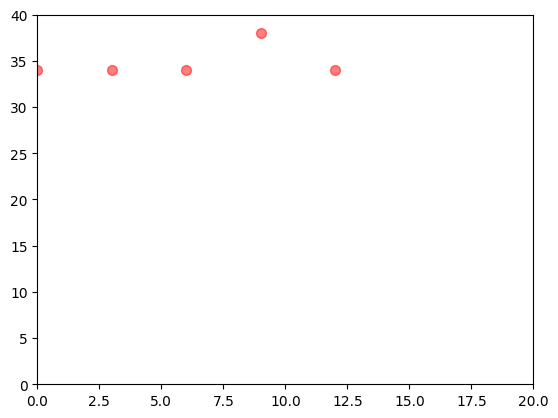

In [15]:
heigths=[5+i for i in range(30)]
z1_variation = []
for h in heigths:
    
    for k in range(T1.n_cond):
        if k < T1.n_cond-1:
            T1.phases[k].pos_y = h  # Assign the radius directly
        else:
            T1.phases[k].pos_y = h+4 #height neutral conductor
    Zall = calc_param(T1, freq, .001, mu_gr, eps_gr)
    
    z1_variation.append(np.imag(Zall.z1)*1e3)    

fig, ax = plt.subplots()
line, = ax.plot(heigths, z1_variation)
ax.set_title("Variation of Z due to heigth")
ax.set_xlabel("Height [m]")
ax.set_ylabel("Reactance [mΩ/km] ")
plt.show()
x=np.zeros((T1.n_cond))
y=np.zeros((T1.n_cond))
for i in range(T1.n_cond): 
    x[i] =T1.phases[i].pos_x
    y[i] =T1.phases[i].pos_y
fig, ax = plt.subplots()
ax.scatter(x, y, c='red', s=50, alpha=0.5)
ax.set_xlim(0, 20)
ax.set_ylim(0, 40)
plt.show()

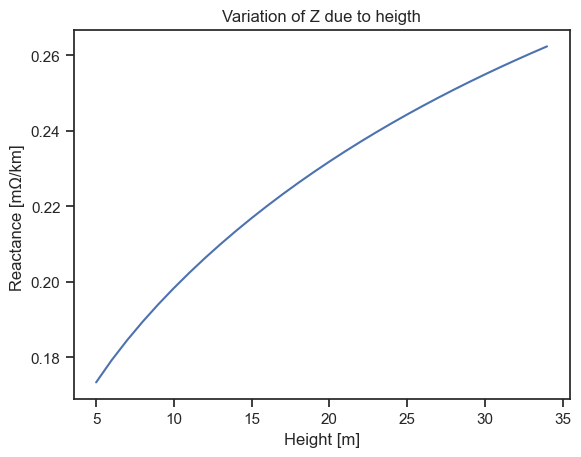

In [ ]:
sep=[1+i*.2 for i in range(30)]

z1_variation = []
for s in sep:
    for j in range(T1.n_cond):
        if j>0 and j < T1.n_cond-1:
            T1.phases[j].pos_x = T1.phases[j-1].pos_x+s  # Assign the radius directly
        elif j>=T1.n_cond-1:
            T1.phases[j].pos_x = T1.phases[j-1].pos_x#height neutral conductor
    Zall = calc_param(T1, freq, sigma_g, mu_gr, eps_gr)
    z1_variation.append(np.imag(Zall.z1)*1e3)
fig, ax = plt.subplots()
line, = ax.plot(heigths, z1_variation)
ax.set_title("Variation of Z due to heigth")
ax.set_xlabel("Height [m]")
ax.set_ylabel("Reactance [mΩ/km] ")
plt.show()

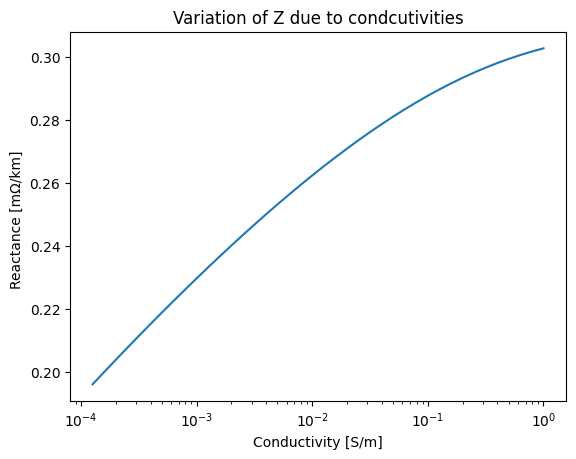

[1.0, 0.7943282347242815, 0.6309573444801932, 0.5011872336272724, 0.39810717055349726, 0.31622776601683794, 0.251188643150958, 0.199526231496888, 0.15848931924611134, 0.12589254117941673, 0.1, 0.07943282347242814, 0.06309573444801933, 0.05011872336272723, 0.039810717055349734, 0.0316227766016838, 0.025118864315095798, 0.0199526231496888, 0.015848931924611134, 0.012589254117941677, 0.010000000000000002, 0.007943282347242814, 0.00630957344480193, 0.0050118723362727255, 0.003981071705534974, 0.00316227766016838, 0.00251188643150958, 0.001995262314968879, 0.0015848931924611143, 0.0012589254117941677, 0.0010000000000000002, 0.0007943282347242814, 0.0006309573444801931, 0.0005011872336272725, 0.0003981071705534974, 0.000316227766016838, 0.000251188643150958, 0.00019952623149688793, 0.00015848931924611145, 0.00012589254117941677]


In [ ]:

z1_variation = []
conductivities=[.1**(i/10) for i in range(40)]
for sigma_g in conductivities:
    Zall = calc_param(T1, freq, sigma_g, mu_gr, eps_gr)
    z1_variation.append(np.imag(Zall.z1)*1e3)

fig, ax = plt.subplots()
line, = ax.plot(conductivities, z1_variation)
ax.set_xscale('log')
ax.set_title("Variation of Z due to condcutivities")
ax.set_xlabel("Conductivity [S/m]")
ax.set_ylabel("Reactance [mΩ/km] ")
plt.show()
print(conductivities)

In [ ]:
display(60*2*np.pi*1e-4*np.log(30/.01))
display(60*2*np.pi*1e-4*np.log(5/.01))
T1.phases[3].pos_y


np.float64(0.30183294638963515)

np.float64(0.2342852057633135)

38